<a href="https://colab.research.google.com/github/YoofKhaneja/Analyzing-Risk-of-CHD-with-Discriminative-NN/blob/master/Siamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing standard libraries

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Seeding values
### This is done so that code values stay uniform

In [0]:
from numpy.random import seed
seed(42)
import tensorflow as tf
tf.random.set_seed(42)

# Reading the data into a dataframe

In [3]:
url = 'https://raw.githubusercontent.com/YoofKhaneja/Analyzing-Risk-of-CHD-with-Discriminative-NN/master/framingham.csv'
hd = pd.read_csv(url)

hd.head(10)

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
5,0,43,2.0,0,0.0,0.0,0,1,0,228.0,180.0,110.0,30.30,77.0,99.0,0
6,0,63,1.0,0,0.0,0.0,0,0,0,205.0,138.0,71.0,33.11,60.0,85.0,1
7,0,45,2.0,1,20.0,0.0,0,0,0,313.0,100.0,71.0,21.68,79.0,78.0,0
8,1,52,1.0,0,0.0,0.0,0,1,0,260.0,141.5,89.0,26.36,76.0,79.0,0
9,1,43,1.0,1,30.0,0.0,0,1,0,225.0,162.0,107.0,23.61,93.0,88.0,0


# Data exploration

In [4]:
print('Total patients: ', hd.shape[0])
print('Total attributes: ', hd.shape[1] - 1)
print('Number of labels: ', 1, '(', hd.columns[15], ')')

Total patients:  4240
Total attributes:  15
Number of labels:  1 ( TenYearCHD )


In [5]:
hd.describe()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,4240.000000,4240.000000,4135.000000,4240.000000,4211.000000,4187.000000,4240.000000,4240.000000,4240.000000,4190.000000,4240.000000,4240.000000,4221.000000,4239.000000,3852.000000,4240.000000
mean,0.429245,49.580189,1.979444,0.494104,9.005937,0.029615,0.005896,0.310613,0.025708,236.699523,132.354599,82.897759,25.800801,75.878981,81.963655,0.151887
std,0.495027,8.572942,1.019791,0.500024,11.922462,0.169544,0.076569,0.462799,0.158280,44.591284,22.033300,11.910394,4.079840,12.025348,23.954335,0.358953
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.070000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.400000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,263.000000,144.000000,90.000000,28.040000,83.000000,87.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


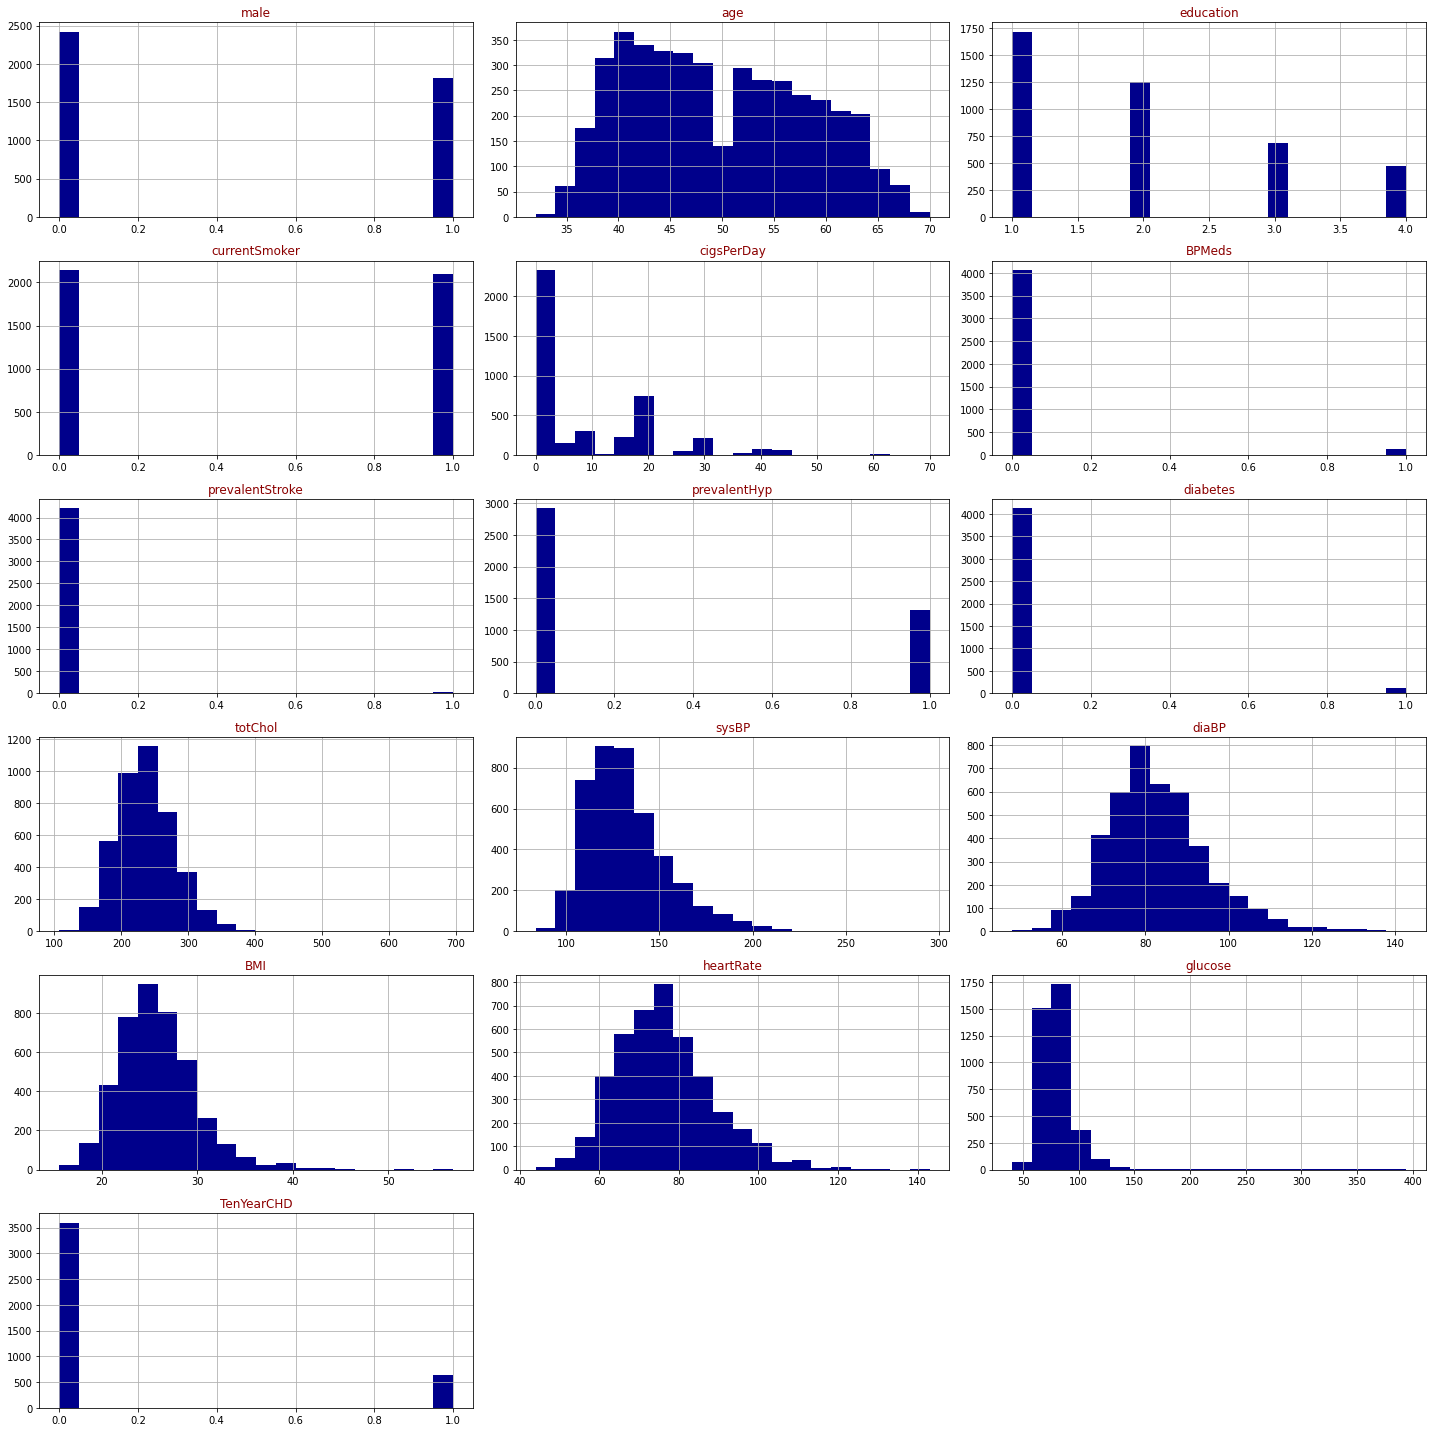

In [6]:
def draw_histograms(dataframe, features, rows, cols):
    fig = plt.figure(figsize = (20, 20))
    for i, feature in enumerate(features):
        ax = fig.add_subplot(rows, cols, i+1)
        dataframe[feature].hist(bins = 20, ax = ax, facecolor = 'DarkBlue')
        ax.set_title(feature, color = 'DarkRed')
    fig.tight_layout()  
    plt.show()
draw_histograms(hd, hd.columns, 6, 3)

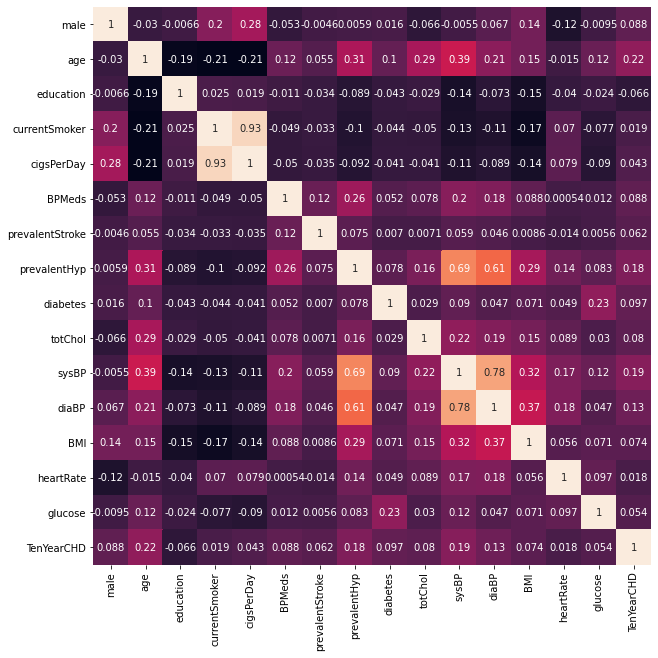

In [7]:
corr = hd.corr(method = 'spearman')

plt.figure(figsize = (10, 16))
sns.heatmap(corr, square = True, cbar = False, annot = True)

Total patients at risk of CHD:  644
Total patients not at risk of CHD:  3596


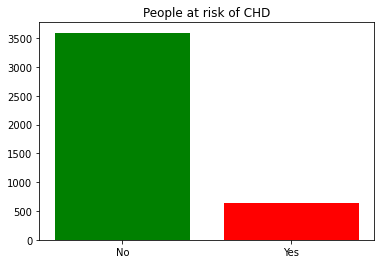

In [8]:
from collections import Counter
chdc = Counter(hd['TenYearCHD'])
print('Total patients at risk of CHD: ', chdc[1])
print('Total patients not at risk of CHD: ', chdc[0])
plt.bar(list(chdc.keys()), chdc.values(), color = ['g', 'r'])
plt.xticks(list(chdc.keys()), ['No', 'Yes'])
plt.title('People at risk of CHD')
plt.show()

In [9]:
print('Missing values: ')
print(hd.isnull().sum())

mv = np.array(hd.isnull().sum())
ta = 0
for t in mv:
    ta += t
print('\nTotal missing attributes: ', ta)

tr = 0
for i in hd.isnull().sum(axis = 1):
    if i > 0:
        tr += 1
print('\nTotal rows with missing data: ', tr)

Missing values: 
male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

Total missing attributes:  645

Total rows with missing data:  582


# Imputing missing values using different techniques

In [10]:
import random
hd.BPMeds = hd.BPMeds.fillna(0)
edu = [1, 2, 3, 4]
c = 0
for i in range(len(hd.education)):
    if hd.education[i] not in edu:
        t = random.randint(1, 4)
        hd.education[i] = t
print(hd.isnull().sum())

male                 0
age                  0
education            0
currentSmoker        0
cigsPerDay          29
BPMeds               0
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64


In [11]:
from fancyimpute import IterativeImputer

hdi = pd.DataFrame(IterativeImputer().fit_transform(hd))

hdi.columns = hd.columns

Using TensorFlow backend.


In [12]:
hdi.isnull().sum()

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

In [13]:
hdi.head(20)

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1.0,39.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,195.0,106.0,70.0,26.97,80.0,77.000000,0.0
1,0.0,46.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,250.0,121.0,81.0,28.73,95.0,76.000000,0.0
2,1.0,48.0,1.0,1.0,20.0,0.0,0.0,0.0,0.0,245.0,127.5,80.0,25.34,75.0,70.000000,0.0
3,0.0,61.0,3.0,1.0,30.0,0.0,0.0,1.0,0.0,225.0,150.0,95.0,28.58,65.0,103.000000,1.0
4,0.0,46.0,3.0,1.0,23.0,0.0,0.0,0.0,0.0,285.0,130.0,84.0,23.10,85.0,85.000000,0.0
5,0.0,43.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,228.0,180.0,110.0,30.30,77.0,99.000000,0.0
6,0.0,63.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,138.0,71.0,33.11,60.0,85.000000,1.0
7,0.0,45.0,2.0,1.0,20.0,0.0,0.0,0.0,0.0,313.0,100.0,71.0,21.68,79.0,78.000000,0.0
8,1.0,52.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,260.0,141.5,89.0,26.36,76.0,79.000000,0.0
9,1.0,43.0,1.0,1.0,30.0,0.0,0.0,1.0,0.0,225.0,162.0,107.0,23.61,93.0,88.000000,0.0


In [14]:
hdi.describe()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000
mean,0.429245,49.580189,1.987264,0.494104,9.067608,0.029245,0.005896,0.310613,0.025708,236.770472,132.354599,82.897759,25.800072,75.878904,81.816655,0.151887
std,0.495027,8.572942,1.022663,0.500024,11.906166,0.168513,0.076569,0.462799,0.158280,44.357009,22.033300,11.910394,4.073174,12.023931,23.012733,0.358953
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.070000,68.000000,72.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.385000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,263.000000,144.000000,90.000000,28.040000,83.000000,85.619087,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


# Formatting the data

In [15]:
hd_ = hdi.copy(deep = True)
hd_['age'] = pd.cut(hd_['age'], 
 
                    5, 
                    labels = [1, 2, 3, 4, 5])
hd_['cigsPerDay'] = pd.cut(hd_['cigsPerDay'], 
                           6, 
                           labels = [1, 2, 3, 4, 5, 6])
hd_['totChol'] = pd.cut(hd_['totChol'], 
                        13, 
                        labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
hd_['sysBP'] = pd.cut(hd_['sysBP'], 
                      10, 
                      labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
hd_['diaBP'] = pd.cut(hd_['diaBP'], 
                      8, 
                      labels = [1, 2, 3, 4, 5, 6, 7, 8])
hd_['BMI'] = pd.cut(hd_['BMI'], 
                    10, 
                    labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
hd_['heartRate'] = pd.cut(hd_['heartRate'], 
                          8, 
                          labels = [1, 2, 3, 4, 5, 6, 7, 8])
hd_['glucose'] = pd.cut(hd_['glucose'], 
                        15, 
                        labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

hd_['age'] = hd_['age'].apply(lambda x: round(x*0.2, 2))
hd_['education'] = hd_['education'].apply(lambda x: round(x*0.25, 2))
hd_['cigsPerDay'] = hd_['cigsPerDay'].apply(lambda x: round(x*0.16, 2))
hd_['totChol'] = hd_['totChol'].apply(lambda x: round(x*0.077, 2))
hd_['sysBP'] = hd_['sysBP'].apply(lambda x: round(x*0.1, 2))
hd_['diaBP'] = hd_['diaBP'].apply(lambda x: round(x*0.125, 2))
hd_['BMI'] = hd_['BMI'].apply(lambda x: round(x*0.1, 2))
hd_['heartRate'] = hd_['heartRate'].apply(lambda x: round(x*0.125, 2))
hd_['glucose'] = hd_['glucose'].apply(lambda x: round(x*0.067, 2))

hd_.head(10)

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1.0,0.2,1.00,0.0,0.16,0.0,0.0,0.0,0.0,0.15,0.2,0.25,0.3,0.38,0.13,0.0
1,0.0,0.4,0.50,0.0,0.16,0.0,0.0,0.0,0.0,0.31,0.2,0.38,0.4,0.62,0.13,0.0
2,1.0,0.6,0.25,1.0,0.32,0.0,0.0,0.0,0.0,0.31,0.3,0.38,0.3,0.38,0.13,0.0
3,0.0,0.8,0.75,1.0,0.48,0.0,0.0,1.0,0.0,0.23,0.4,0.50,0.4,0.25,0.20,1.0
4,0.0,0.4,0.75,1.0,0.32,0.0,0.0,0.0,0.0,0.31,0.3,0.50,0.2,0.50,0.13,0.0
5,0.0,0.4,0.50,0.0,0.16,0.0,0.0,1.0,0.0,0.23,0.5,0.75,0.4,0.38,0.20,0.0
6,0.0,1.0,0.25,0.0,0.16,0.0,0.0,0.0,0.0,0.23,0.3,0.25,0.5,0.25,0.13,1.0
7,0.0,0.4,0.50,1.0,0.32,0.0,0.0,0.0,0.0,0.39,0.1,0.25,0.2,0.38,0.13,0.0
8,1.0,0.6,0.25,0.0,0.16,0.0,0.0,1.0,0.0,0.31,0.3,0.50,0.3,0.38,0.13,0.0
9,1.0,0.4,0.25,1.0,0.48,0.0,0.0,1.0,0.0,0.23,0.4,0.62,0.2,0.50,0.20,0.0


# Generating pairs for the Siamese network

In [16]:
import random

hd1 = hd_[hd_['TenYearCHD'] == 1.0].astype('float32')
hd0 = hd_[hd_['TenYearCHD'] == 0.0].astype('float32')

hd1x = hd1.iloc[:, :-1]
hd1y = hd1.iloc[:, -1]
hd0x = hd0.iloc[:, :-1]
hd0y = hd0.iloc[:, -1]

hd1x = hd1x.to_numpy()
hd1y = hd1y.to_numpy()
hd0x = hd0x.to_numpy()
hd0y = hd0y.to_numpy()

p01 = []
p11 = []
p00 = []


for i in range(len(hd1x)):
    for j in range(len(hd0x)):
        p01 += [[hd0x[j], hd1x[i]]]
for i in range(len(hd1x)):
    for j in range(len(hd1x)):
        p11 += [[hd1x[j], hd1x[i]]]
for i in range(len(hd0x)):
    for j in range(len(hd0x)):
        p00 += [[hd0x[j], hd0x[i]]]

print([len(p01), len(p00), len(p11)])

[2315824, 12931216, 414736]


In [17]:
p = []
label = []
for i in range(414736):
    t1 = random.randint(0, 2315823)
    t2 = random.randint(0, 12931215)
    p.append(p01[t1])
    label.append(0)
    if i%2 == 0:
        p.append(p00[t2])
        label.append(1)
    else:
        p.append(p11[i])
        label.append(1)

X = np.array(p)
Y = np.array(label)

print([len(X), len(Y)])

[829472, 829472]


In [18]:
for _ in range(100):
    p = np.random.permutation(829472)
    X = X[p]
    Y = Y[p]

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

print(y_train[10:20])

(663577, 2, 15)
(165895, 2, 15)
(663577,)
(165895,)
[0 0 1 1 1 0 1 0 0 1]


In [19]:
cc = Counter(y_test)
print(cc[1])
print(cc[0])

83004
82891


# Creating and compiling the neural network model

In [0]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Lambda
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K

def create_base_network(input_shape):
    input = Input(shape =  input_shape)
    x = input
    x = Dense(256, 
              input_shape = (15,), 
              activation='relu', 
              name = 'D1')(x)
              #activity_regularizer = regularizers.l2(0.01))(x)
    x = Dropout(0.2)(x)
    x = Dense(256, 
              activation='relu', 
              name = 'D2')(x)
              #activity_regularizer = regularizers.l2(0.01))(x)
    x = Dropout(0.2)(x)
    x = Dense(256, 
              activation='relu',
              name = 'Embeddings')(x)
              #activity_regularizer = regularizers.l2(0.01))(x)
    return Model(input, x)

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis = 1, keepdims = True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    print(shape1)
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [21]:
input_shape = (15,)
base_network = create_base_network(input_shape)

input_a = Input(shape = input_shape)
input_b = Input(shape = input_shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance, 
                  output_shape = eucl_dist_output_shape, 
                  name = 'Distance')([processed_a, processed_b])

model = Model([input_a, input_b], distance)

(None, 256)


In [22]:
rms = RMSprop()

model.compile(loss = contrastive_loss, 
              optimizer = rms, 
              metrics=[accuracy])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 15)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 15)           0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 256)          135680      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
Distance (Lambda)               (None, 1)            0           model_1[1][0]              

# Defining functions to better understand the training process
### One function prints the average accuracy and loss, the other plots the values for loss and accuracy accross a training session


In [0]:
def stats_avg(history, i):
    val_acc = np.array(history.history['val_accuracy'])
    val_loss = np.array(history.history['val_loss'])
    model_acc = np.array(history.history['accuracy'])
    model_loss = np.array(history.history['loss'])
    print('Average validation loss:', val_loss.sum()/i)
    print('Average validation accuracy:', val_acc.sum()/i)
    print('Average loss:', model_loss.sum()/i)
    print('Average accuracy:', model_acc.sum()/i)

In [0]:
def plots(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

# Training the network

Train on 497682 samples, validate on 165895 samples
Epoch 1/64
497682/497682 [==============================] - 6s 13us/step - loss: 0.2465 - accuracy: 0.5521 - val_loss: 0.2513 - val_accuracy: 0.5618
Epoch 2/64
497682/497682 [==============================] - 4s 9us/step - loss: 0.2342 - accuracy: 0.6008 - val_loss: 0.2321 - val_accuracy: 0.6145
Epoch 3/64
497682/497682 [==============================] - 5s 9us/step - loss: 0.2095 - accuracy: 0.6689 - val_loss: 0.2099 - val_accuracy: 0.6650
Epoch 4/64
497682/497682 [==============================] - 4s 9us/step - loss: 0.1705 - accuracy: 0.7520 - val_loss: 0.1490 - val_accuracy: 0.7883
Epoch 5/64
497682/497682 [==============================] - 4s 9us/step - loss: 0.1276 - accuracy: 0.8316 - val_loss: 0.1009 - val_accuracy: 0.8669
Epoch 6/64
497682/497682 [==============================] - 4s 9us/step - loss: 0.0957 - accuracy: 0.8837 - val_loss: 0.0682 - val_accuracy: 0.9236
Epoch 7/64
497682/497682 [==============================] -

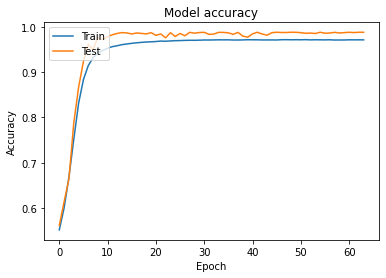

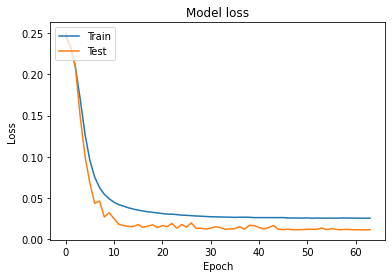

In [25]:
for i in range(1):
    history = model.fit([x_train[:, 0], x_train[:, 1]], y_train,
          batch_size = 512,
          epochs = 64,
          validation_split = 0.25,
          verbose = 1)
    stats_avg(history, 32)
    plots(history)

# Saving the model

In [26]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
save_path_model = 'gdrive/My Drive/Models/siamese_model.h5'
model.save(save_path_model)

In [28]:
names = [weight.name for layer in model.layers for weight in layer.weights]
weights = model.get_weights()

for name, weight in zip(names, weights):
    print(name, weight)

D1/kernel:0 [[-0.05749272  0.04751353 -0.23818801 ...  0.03735742 -0.33328962
  -0.08933926]
 [ 0.01299236  0.09452199 -0.21442114 ... -0.1731299  -0.01143719
  -0.22052874]
 [ 0.14513586  0.13918872 -0.30923232 ... -0.02323215 -0.08773784
   0.23446484]
 ...
 [ 0.38043544 -0.46346092 -0.29547444 ...  0.2845455  -0.37202066
   0.39623293]
 [-0.05282679 -0.3226396   0.10107949 ... -0.07797965 -0.06084179
  -0.1275468 ]
 [-0.40525195  0.5370607  -0.20006381 ... -0.71908504  0.5379067
  -0.47266188]]
D1/bias:0 [-0.15511109 -0.09580822  0.07691616 -0.04176274 -0.03467711 -0.10334882
  0.06198083  0.07084294  0.25664642  0.17286015 -0.11204728  0.22008406
  0.05147954 -0.04589568 -0.19324154  0.18195556 -0.30433938 -0.04713337
  0.05996617 -0.05217293 -0.02437735  0.07833093 -0.32060698  0.24038291
 -0.173455    0.04091115 -0.0201078   0.16952324 -0.01266024 -0.02735543
 -0.020313   -0.0257768   0.         -0.13920234 -0.00577385 -0.03396915
  0.21011771 -0.10924427  0.          0.05826471 

# Testing and evaluating the model

In [0]:
p = np.random.permutation(165895)
x_test = x_test[p]
y_test = y_test[p]

y_pred = model.predict([x_test[:, 0], x_test[:, 1]])
y_pred = (y_pred <= 0.5)

In [30]:
evaluation = model.evaluate([x_train[:, 0], x_train[:, 1]], y_train)
print('Loss:', evaluation[0])
print('Accuracy:', evaluation[1])

663577/663577 [==============================] - 33s 49us/step
Loss: 0.011173211630152438
Accuracy: 0.9880045056343079


In [31]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
conf_matrix = pd.DataFrame(data = cm, 
                           columns = ['Predicted: 0', 'Predicted: 1'], 
                           index = ['Actual:0', 'Actual:1'])

print('Accuracy:', accuracy_score(y_test, y_pred))
conf_matrix

Accuracy: 0.9870942463606498


,Predicted: 0,Predicted: 1
Actual:0,81831,1060
Actual:1,1081,81923


In [32]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     82891
           1       0.99      0.99      0.99     83004

    accuracy                           0.99    165895
   macro avg       0.99      0.99      0.99    165895
weighted avg       0.99      0.99      0.99    165895



In [33]:
test_pairs = []
test_pairs += [[hd1x[0], hd1x[1]]]
test_pairs += [[hd0x[1], hd0x[0]]]
test_pairs += [[hd0x[100], hd1x[200]]]
test_pairs += [[hd1x[100], hd0x[200]]]
test_pairs = np.array(test_pairs)
test_preds = model.predict([test_pairs[:, 0], test_pairs[:, 1]])
test_preds = (test_preds <= 0.5)
test_preds

array([[ True],
       [ True],
       [False],
       [False]])